In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns


# Load your data (assume already loaded as df)
df = pd.read_csv('patient_level_comprehensive_features_fixed.csv')
#csv filled with blanks on shell 0 columns still - delete and keep the boundary_shell0 columns only? 

df = df.drop(columns=['patient_id'])


In [16]:
#data pre-prcessing: need to convert clinical data using one-hot numeric arrays? 
columns_by_index = ['age_at_mri', 'sex', 'overall_survival_days', 'mgmt_status', 'mgmt_index', '1p19q', 'idh_status', 'eor']

for column in columns_by_index:
    unique_values = df[column].unique()
    print(f"Unique values in column '{column}': {unique_values}")

#Notes-what to do with unknown/nan data in categorical data and in 'overall_survival_days' 'mgmt_index'?

#all categorical data being encoded, unknowns included
df_encoded = pd.get_dummies(df, columns=['sex', 'mgmt_status', '1p19q', 'idh_status', 'eor'], drop_first=False)

print("\nOne-Hot Encoded DataFrame (Pandas):")
print(df_encoded)
    


#testing data w/out clinical features 
#indices_to_drop = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
#columns_by_index = df.columns[indices_to_drop].tolist()
#df_dropped = df.drop(columns=columns_by_index)


#df = df.drop(columns=[indices_to_drop])
#print(df_dropped)



Unique values in column 'age_at_mri': [66 80 70 68 39 74 65 64 50 57 54 51 49 41 61 67 34 83 78 40 37 63 69 52
 53 58 38 32 48 55 79 71 46 56 76 84 77 60 62 72 25 45 29 17 47 36 81 27
 33 42 26 75 59 35 43 73 86 89 22 31 30 24 44 28 23 82 19 94 21 85]
Unique values in column 'sex': ['M' 'F']
Unique values in column 'overall_survival_days': [1303.  274.  417.  185.  389.   17.  133.   15.  322.  313.   54.   14.
  241. 1449.  719.  551. 1759.  533. 1161.  653.  465.  236.  298.   75.
  824.  105. 1489.   52.  132. 1673.  460.  152.  134.  716.  128.  635.
 1116.  930. 1718.  178.  385.  721.  554.  575. 1328.  207.  224. 1540.
  223. 1907.  287.  187.  167. 1913.  299.  336.  245.  678.  315.  184.
 1617.  583.  421.  108.  142.  354.  560.  253.    6.  260.  902.  232.
  266.  406. 1797. 1785.  749.  463.  567.  994.  161.  777.  591.  110.
  472.  705.  798. 1694.   70.  667.  351.  175. 1715.  611.   39.  301.
 1351.   92.  430. 1611.  162. 1650.  879. 1024.  485. 1299.  919. 1296.
 

In [17]:
#replacing NAs and unknowns with 0s, change before submitting

#note that survival days has missing value-what to do with that? 

missing_counts = df_encoded.isna().sum()
pd.options.display.max_rows = 4000

#print(sum(missing_counts), 'NA total')



#print(missing_counts)

df_filled = df_encoded.fillna(0)
print('sum of NAs', sum(df_filled.isna().sum()>0))

#confirm no NAs 
#print(sum(df_filled.isna().sum()>0))

#replacing unknowns in clinical data with 0, change before final 
df_clean = df_filled.replace('unknown', '0')
#print(df_clean)





sum of NAs 0


In [18]:
X = df_clean.drop(columns=['who_grade']) #replace to df 
#print(X)
y = df_clean['who_grade']
#print(y)


In [19]:
# Split into train/test with stratification to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, stratify=y, random_state=42
)
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)






X_train (400, 106)
X_test (100, 106)
y_train (400,)
y_test (100,)


In [20]:
# Compute class weights to address imbalance
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, weights))



In [21]:
# Define the pipeline (scaling + random forest)
pipeline = Pipeline([
('scaler', StandardScaler()), # optional depending on feature types
('rf', RandomForestClassifier(
n_estimators=100,    #if do more, could stabilize??
class_weight=class_weight_dict,
random_state=42,
n_jobs=-1
))
])



In [22]:
# Repeated stratified K-Fold cross-validation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)



In [23]:
# Cross-validation on training data
scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
print(f'Cross-validated Accuracy: {np.mean(scores):.4f} ± {np.std(scores):.4f}')
cv_scores_stored = scores

Cross-validated Accuracy: 0.8642 ± 0.0195


In [24]:
# Fit on full training set
pipeline.fit(X_train, y_train)

# Evaluate on held-out test set
y_pred = pipeline.predict(X_test)
print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report on Test Set:
              precision    recall  f1-score   support

           2       0.70      0.64      0.67        11
           3       0.00      0.00      0.00         9
           4       0.89      0.99      0.93        80

    accuracy                           0.86       100
   macro avg       0.53      0.54      0.53       100
weighted avg       0.79      0.86      0.82       100

Confusion Matrix:
[[ 7  1  3]
 [ 2  0  7]
 [ 1  0 79]]


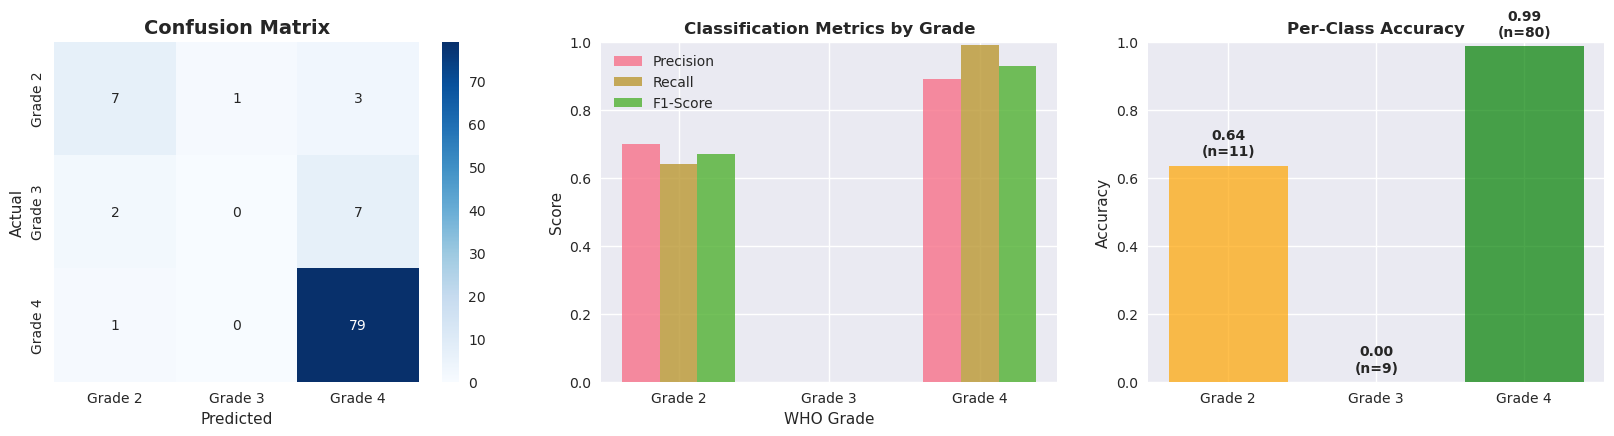

In [29]:
# Set up the plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
fig = plt.figure(figsize=(20, 15))

# 1. Confusion Matrix Heatmap
plt.subplot(3, 3, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Grade 2', 'Grade 3', 'Grade 4'],
            yticklabels=['Grade 2', 'Grade 3', 'Grade 4'])
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# 2. Classification Metrics
plt.subplot(3, 3, 2)
grades = ['Grade 2', 'Grade 3', 'Grade 4']
precision = [0.70, 0.00, 0.89]
recall = [0.64, 0.00, 0.99]
f1 = [0.67, 0.00, 0.93]

x = np.arange(len(grades))
width = 0.25

plt.bar(x - width, precision, width, label='Precision', alpha=0.8)
plt.bar(x, recall, width, label='Recall', alpha=0.8)
plt.bar(x + width, f1, width, label='F1-Score', alpha=0.8)

plt.xlabel('WHO Grade')
plt.ylabel('Score')
plt.title('Classification Metrics by Grade', fontweight='bold')
plt.xticks(x, grades)
plt.legend()
plt.ylim(0, 1.0)

# 3. Grade-wise Performance
plt.subplot(3, 3, 3)
grades = ['Grade 2', 'Grade 3', 'Grade 4']
support = [11, 9, 80]  # From your classification report
correct_predictions = [7, 0, 79]  # From confusion matrix diagonal
accuracy_by_grade = [c/s for c, s in zip(correct_predictions, support)]

bars = plt.bar(grades, accuracy_by_grade, color=['orange', 'red', 'green'], alpha=0.7)
plt.ylim(0, 1.0)
plt.title('Per-Class Accuracy', fontweight='bold')
plt.ylabel('Accuracy')

# Add value labels
for bar, acc, sup in zip(bars, accuracy_by_grade, support):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{acc:.2f}\n(n={sup})', ha='center', va='bottom', fontweight='bold')

